In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy

In [2]:
def load_cfar10_batch(path):
    """ Based on: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
    """
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(batch['labels'])
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

In [4]:
# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


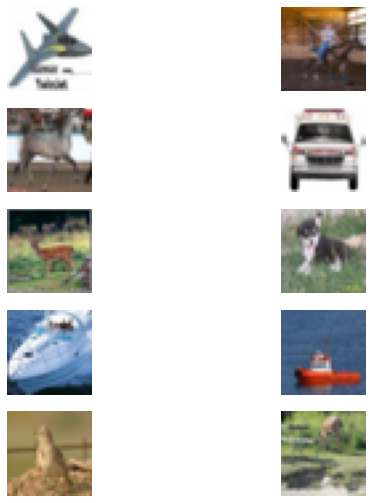

In [5]:
# show some random pics

show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)
x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(show_n // 2, 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    col_idx = 1 - int(idx % 2 == 0)
    ax = axs[idx // 2, col_idx]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [6]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [7]:
print(np.mean(x_train, axis=0))
print(np.mean(x_train, axis=0).shape)
print(np.std(x_train, axis=0))
print(x_train.shape)

print(np.mean(x_val, axis=0))
print(np.std(x_val, axis=0))

print(np.mean(x_test, axis=0))
print(np.std(x_test, axis=0))

print(y_train.shape)
print(y_train.shape[0])

[ 1.14188659e-15 -6.18216589e-16  8.90314489e-15 ...  5.31555910e-15
  8.26625435e-15  1.97581895e-14]
(3072,)
[1. 1. 1. ... 1. 1. 1.]
(10000, 3072)
[-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
[0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
[-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
[0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]
(10000,)
10000


In [8]:
x_train.shape

(10000, 3072)

In [9]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_train.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_train])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_val.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_val])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

iteration 0: train loss 2.471734, acc 0.082700
iteration 0: val loss 2.459326, acc 0.086300
iteration 10: train loss 1.739543, acc 0.405800
iteration 10: val loss 1.829408, acc 0.368100
iteration 20: train loss 1.678140, acc 0.427300
iteration 20: val loss 1.806344, acc 0.378000
iteration 30: train loss 1.643078, acc 0.444400
iteration 30: val loss 1.797954, acc 0.382700


In [10]:
def eval_numerical_gradient(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [ ]:
def eval_numerical_gradient_double(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxph = f(x) # evalute f(x + h)
        
        x[ix] = old_value - h # decrease by h
        fxmh = f(x) # evalute f(x - h)
        x[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        grad[ix] = (fxph - fxmh) / (2*h) # the slope
        it.iternext() # step to next dimension

    return grad

In [ ]:
def loss(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return loss

def grad(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return dW

In [ ]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
    return loss(x_train[:2], y_train[:2], W)

W = np.random.rand(3072, 10) * 0.001 # random weight vector
df = eval_numerical_gradient_double(CIFAR10_loss_fun, W) # get the gradient

In [ ]:
df_ana = grad(x_train[:2], y_train[:2], W)

In [ ]:
v = np.abs(df_ana - df)/(np.maximum(np.abs(df_ana), np.abs(df)))

In [ ]:
v

In [ ]:
np.testing.assert_array_almost_equal(df, df_ana, decimal=6)

In [ ]:
print(np.max(v))
assert np.all(v < 10e-5)

In [ ]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.0001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_train.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_train].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(num_examples), y_train] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_val.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_val].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_val] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_batch.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_batch].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_batch] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        

        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(num_examples),y_batch] -= valid_margin_count
        
        dW = np.dot(x_batch.T, margin) / num_examples #? why divide
        
        dW += reg*W
        
        db = np.sum(margin, axis=0, keepdims=True)
        
        """num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient"""


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

In [11]:
class Loss():
    def __init__(self, ):
        self.cache = {}

class CategoricalHingeLoss(Loss):
    def __init__(self, ):
        super().__init__()
        
    def compute_loss(self, scores, y, layers_reg_loss):
        c = scores.shape[1]
        n = y.shape[0]
        
        correct_class_scores = scores[range(n), y].reshape(n, 1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(n), y] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / n

        loss = data_loss + layers_reg_loss
        
        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(n), y] -= valid_margin_count
        margin /= n
        self.cache["g"] = deepcopy(margin)
        
        return loss
    
    def grad(self, ):
        if "g" in self.cache.keys():
            return deepcopy(self.cache["g"])
        else:
            return None

class CategoricalCrossEntropyLoss(Loss):
    def __init__(self, ):
        super().__init__()
    
    def compute_loss(self, scores, y, layers_reg_loss):
        """
        scores.shape=(batch_size, K)
        y.shape=(K,)
        l.shape = ()
        
        scores are probabilities from softmax
        """
        self.cache["g"] = deepcopy(y)
        
        n = y.shape[0]
        
        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(scores[range(n), y])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs) / n
        
        loss = data_loss + layers_reg_loss
        
        return loss
    
    def grad(self, ):
        if "g" in self.cache.keys():
            return deepcopy(self.cache["g"])
        else:
            return None
        

In [12]:
class Activation():
    def __init__(self, ):
        self.cache = {}
    
    
class LinearActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        return deepcopy(z)
    
    def backward(self, g):
        return deepcopy(g)
    
    def __repr__(self):
        repr_str = "linear"
        return repr_str
    
    
class ReLUActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        a = np.maximum(0, z)
        self.cache["a"] = deepcopy(a)
        return a
    
    def backward(self, g_in):
        a = self.cache["a"]
        g_out = deepcopy(g_in)
        g_out[a <= 0] = 0.0
        return g_out
    
    def __repr__(self):
        repr_str = "relu"
        return repr_str
    
class SoftmaxActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        """
        z.shape = (batch_size, K)
        a.shape = (batch_size, K)
        """
        # avoid numeric instability
        z -= np.max(z, axis=1, keepdims=True)
        
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_z = np.exp(z)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        a = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        self.cache["a"] = deepcopy(a)
        
        return a
        
    def backward(self, g_in):
        # dscores.shape = (batch_size, K)
        # g_in is y, y.shape = (K,)G IN
        # g_out.shape = (batch_size, K)

        n = g_in.shape[0]
        a = self.cache["a"]
        g_out = deepcopy(a)
        g_out[range(n), g_in] -= 1
        g_out /= n
        
        return g_out
    
    def __repr__(self):
        repr_str = "softmax"
        return repr_str

In [13]:
def test_categoical_cross_entropy_loss():
    
    # from: https://cs231n.github.io/linear-classify/
    scores = np.array([[0.016, 0.631, 0.353]])
    y = np.array([2])
    
    categoical_cross_entropy_loss = CategoricalCrossEntropyLoss()
    layers_reg_loss = 0
    
    loss = categoical_cross_entropy_loss.compute_loss(scores, y, layers_reg_loss)
    np.testing.assert_almost_equal(loss, 1.0412872220488403)
    
    # automated test
    batch_size = 5
    out_dim = 10
    size = (batch_size, out_dim)
    scores = np.random.normal(loc=0, scale=1, size=size)
    
    softmax_activation = SoftmaxActivation()
    scores = softmax_activation.forward(scores)
    
    y = np.random.randint(low=0, high=out_dim, size=(batch_size,))
    
    layers_reg_loss = 0
    categoical_cross_entropy_loss = CategoricalCrossEntropyLoss()
    
    loss = categoical_cross_entropy_loss.compute_loss(scores, y, layers_reg_loss)
    
    n = y.shape[0]
        
    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(scores[range(n), y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs) / n

    loss_true = data_loss + layers_reg_loss
    
    np.testing.assert_almost_equal(loss, loss_true)
    
    print("test_categoical_cross_entropy_loss passed")

def test_categorical_hinge_loss():
    pass
    
test_categoical_cross_entropy_loss()

test_categoical_cross_entropy_loss passed


In [14]:
def test_linear_activation():
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    linear_activation = LinearActivation()
    fw = linear_activation.forward(data)
    np.testing.assert_array_equal(data, fw)
    
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    bw = linear_activation.backward(data)
    np.testing.assert_array_equal(data, bw)
    
    print("test_linear_activation passed")

def test_relu_activation():
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    relu_activation = ReLUActivation()
    fw = relu_activation.forward(data)
    fw_true = np.maximum(0, data)
    
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    bw = relu_activation.backward(data)
    bw_true = np.copy(data)
    bw_true[fw_true <= 0] = 0.0
    
    np.testing.assert_array_equal(fw, fw_true)
    np.testing.assert_array_equal(bw, bw_true)
    
    print("test_relu_activation passed")
    
def test_softmax_activation():
    # from: https://cs231n.github.io/linear-classify/
    z = np.array([[-2.85, 0.86, 0.28]])
    softmax_activation = SoftmaxActivation()
    fw = softmax_activation.forward(z)
    fw_true = np.array([[0.01544932, 0.63116335, 0.35338733]])
    np.testing.assert_almost_equal(fw, fw_true)
    
    # automated testing
    labels = 3
    batch_size = 5
    size = (batch_size, labels)
    z = np.random.normal(loc=0, scale=1, size=size)
    
    softmax_activation = SoftmaxActivation()
    fw = softmax_activation.forward(z)
    
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    fw_true = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    size = (batch_size,)
    g_in = np.random.randint(low=0, high=labels, size=size)
    
    bw = softmax_activation.backward(g_in)
    
    n = g_in.shape[0]
    bw_true = deepcopy(fw_true)
    bw_true[range(n), g_in] -= 1
    bw_true /= n
    
    assert fw.shape == (batch_size, 3)
    assert bw.shape == (batch_size, 3)
    np.testing.assert_array_equal(fw, fw_true)
    np.testing.assert_array_equal(bw, bw_true)
    
    print("test_softmax_activation passed")

test_linear_activation()
test_relu_activation()
test_softmax_activation()



test_linear_activation passed
test_relu_activation passed
test_softmax_activation passed


In [15]:
class Initializer():
    def __init__(self,):
        pass

    
class NormalInitializer():
    def __init__(self, seed=None, **params):
        super().__init__()
        self.seed = seed
        self.coeff = params["coeff"]
        self.loc = params["loc"]
        self.scale = params["scale"]
        
    def initialize(self, size):
        np.random.seed(self.seed)
        return self.coeff * np.random.normal(loc=self.loc, scale=self.scale, size=size)
    
    def __repr__(self):
        repr_str = "normal ~ " + f"{self.coeff} x ({self.loc}, {self.scale})"
        return repr_str
    
    
class XavierInitializer(Initializer):
    def __init__(self,):
        super().__init__()

In [16]:
def test_normal_initializer(seed=None):
    assert seed is not None, "seed cannot be None"
    
    size = (5,5)
    coeff = 1.0
    loc = 0.0
    scale = 1.0
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    normal_initializer = NormalInitializer(seed=seed, **params)
    w = normal_initializer.initialize(size=size)
    
    np.random.seed(seed)
    w_true = coeff * np.random.normal(loc=loc, scale=scale, size=size)
    
    np.testing.assert_array_equal(w, w_true)
    
    print("test_normal_initializer passed")
    
test_normal_initializer(seed=100)

test_normal_initializer passed


In [17]:
class Regularizer():
    def __init__(self, reg_rate):
        self.reg_rate = reg_rate
        
class L2Regularizer(Regularizer):
    def __init__(self, reg_rate):
        super().__init__(reg_rate)
        
    def loss(self, param):
        return 0.5 * self.reg_rate * np.sum(np.power(param, 2))
    
    def grad(self, param):
        return self.reg_rate * param
    
    def __repr__(self, ):
        repr_str = "l2"
        return repr_str

In [18]:
def test_l2_regularizer(seed=None):
    np.random.seed(seed)
    reg_rate = np.random.uniform(low=0, high=1)
    l2_regularizer = L2Regularizer(reg_rate=reg_rate)
    
    size = (5,3)
    param = np.random.normal(loc=0, scale=1, size=size)
    
    loss_true = 0.5 * reg_rate * np.sum(np.power(param, 2))
    loss = l2_regularizer.loss(param=param)
    
    np.testing.assert_array_equal(loss, loss_true)
    
    grad_true = reg_rate * param
    grad = l2_regularizer.grad(param=param)

    np.testing.assert_array_equal(grad, grad_true)

    print("test_l2_regularizer passed")
    
test_l2_regularizer(seed=None)

test_l2_regularizer passed


In [19]:
class Dense():
    def __init__(self, in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation):
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        
        self.w = kernel_initializer.initialize(size=(in_dim, out_dim))
        self.b = bias_initializer.initialize(size=(1, out_dim))
        
        self.kernel_regularizer = kernel_regularizer
        
        self.activation = activation
        
        self.cache = {}
        self.grads = {}
        
    def get_w(self,):
        return deepcopy(self.w)
    
    def get_b(self,):
        return deepcopy(self.b)
    
    def set_w(self, w):
        self.w = deepcopy(w)
    
    def set_b(self, b):
        self.b = deepcopy(b)
    
    def get_dw(self, ):
        if "dw" in self.grads.keys():
            dw = self.grads["dw"]
            ret = deepcopy(dw)
        else:
            ret = None
        
        return ret
    
    def get_db(self, ):
        if "db" in self.grads.keys():
            db = self.grads["db"]
            ret = deepcopy(db)
        else:
            ret = None
        
        return ret
    
    def get_reg_loss_w(self, ):
        if self.kernel_regularizer is None:
            return 0.0
        else:
            return self.kernel_regularizer.loss(self.w)
    
    def get_reg_grad_w(self, ):
        if self.kernel_regularizer is None:
            return 0.0
        else:
            return self.kernel_regularizer.grad(self.w)
            
    def forward(self, x):
        """
        x.shape = (batch_size, in_dim)
        self.w.shape=(in_dim, out_dim)
        self.b.shape=(1, out_dim)
        z.shape = (batch, out_dim)
        a.shape = (batch, out_dim)
        """
        self.cache["x"] = deepcopy(x)
        z = np.dot(x, self.w) + self.b
        a = self.activation.forward(z)
        
        return a
    
    def backward(self, g_in):
        """
        g_in.shape = (batch_size, out_dim)
        self.cache["x"].shape = (batch_size, in_dim)
        self.w.shape=(in_dim, out_dim)
        self.b.shape=(1, out_dim)
        dw.shape=(in_dim, out_dim)
        db.shape=(1, out_dim)
        g_out.shape = (batch_size, in_dim)
        """
        x = self.cache["x"]
        g_a = self.activation.backward(g_in)
        
        dw = np.dot(deepcopy(x).T, g_a)
        dw += self.get_reg_grad_w()
        
        db = np.sum(g_a, axis=0, keepdims=True)
        
        self.grads["dw"] = deepcopy(dw)
        self.grads["db"] = deepcopy(db)
        
        g_out = np.dot(g_a, self.w.T)
        
        return g_out
    
    def __repr__(self, ):
        repr_str = "dense: \n" \
            + "\t w -- init:" + self.kernel_initializer.__repr__() \
                + ", reg: " + self.kernel_regularizer.__repr__() + "\n" \
            + "\t b -- init: " + self.bias_initializer.__repr__() + "\n" \
            + "\t activation: " + self.activation.__repr__() + "\n"
        return repr_str

In [20]:
def test_dense_param_init(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 5
    coeff = 1.0
    loc = 0.0
    scale = 1.0
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    activation = None
    
    dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)
    
    w = dense.get_w()
    b = dense.get_b()
    
    assert w.shape == (in_dim, out_dim)
    assert b.shape == (1, out_dim)
    np.testing.assert_array_equal(w, w_true)
    np.testing.assert_array_equal(b, b_true)
    
    print("test_dense_param_init passed")
    
test_dense_param_init(seed=100)

test_dense_param_init passed


In [21]:
def test_dense_forward(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    loc = 0.0
    scale = 1.0
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    linear_activation = LinearActivation()
    relu_activation = ReLUActivation()
    softmax_activation = SoftmaxActivation()
    
    activations = [linear_activation, relu_activation, softmax_activation]
    
    for activation in activations:
        print(f"activation: {type(activation)}")
    
        dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)

        w = dense.get_w()
        b = dense.get_b()
        
        assert w.shape == (in_dim, out_dim)
        assert b.shape == (1, out_dim)

        np.testing.assert_array_equal(w, w_true)
        np.testing.assert_array_equal(b, b_true)

        size = (batch_size, in_dim)
        np.random.seed(seed + 1)
        x = np.random.normal(loc=0, scale=1, size=size)

        z_true = np.dot(x, w_true) + b_true
        a_true = activation.forward(z_true)

        a = dense.forward(x)
        
        assert a.shape == (batch_size, out_dim)
        
        np.testing.assert_array_equal(a, a_true)
    
    print("test_dense_forward_with_linear_activation passing")

test_dense_forward(seed=100)

activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
activation: <class '__main__.SoftmaxActivation'>
test_dense_forward_with_linear_activation passing


In [22]:
def test_dense_backward_relu_linear(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    loc = 0.0
    scale = 1.0
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    linear_activation = LinearActivation()
    relu_activation = ReLUActivation()
    
    activations = [linear_activation, relu_activation]
    
    for activation in activations:
        
        print(f"activation: {type(activation)}")
        
        dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)

        w = dense.get_w()
        b = dense.get_b()
        
        assert w.shape == (in_dim, out_dim)
        assert b.shape == (1, out_dim)

        np.testing.assert_array_equal(w, w_true)
        np.testing.assert_array_equal(b, b_true)

        x_size = (batch_size, in_dim)
        np.random.seed(seed + 1)
        x = np.random.normal(loc=0, scale=1, size=x_size)

        z_true = np.dot(x, w_true) + b_true
        a_true = activation.forward(z_true)

        a = dense.forward(x)
        
        assert a.shape == (batch_size, out_dim)

        np.testing.assert_array_equal(a, a_true)
        
        g_in_size = (batch_size, out_dim)
        np.random.seed(seed + 2)
        g_in = np.random.normal(loc=0, scale=1, size=g_in_size)
        
        g_a_true = activation.backward(g_in)
        
        dw_true = np.dot(x.T, g_a_true)
        db_true = np.sum(g_a_true, axis=0, keepdims=True)
        
        g_out_true = np.dot(g_a_true, w_true.T)
        
        g_out = dense.backward(g_in)
        
        dw = dense.get_dw()
        db = dense.get_db()
        
        assert g_out.shape == (batch_size, in_dim)
        assert dw.shape == (in_dim, out_dim)
        assert db.shape == (1, out_dim), f"db.shape={db.shape}"
        
        np.testing.assert_array_equal(g_out, g_out_true)
        np.testing.assert_array_equal(dw, dw_true)
        np.testing.assert_array_equal(db, db_true)
    
    print("test_dense_backward_relu_linear passing")

test_dense_backward_relu_linear(seed=100)

activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
test_dense_backward_relu_linear passing


In [23]:
def test_dense_backward_softmax(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    loc = 0.0
    scale = 1.0
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    softmax_activation = SoftmaxActivation()
        
    dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, 
                 softmax_activation)

    w = dense.get_w()
    b = dense.get_b()

    assert w.shape == (in_dim, out_dim)
    assert b.shape == (1, out_dim)

    np.testing.assert_array_equal(w, w_true)
    np.testing.assert_array_equal(b, b_true)

    x_size = (batch_size, in_dim)
    np.random.seed(seed + 1)
    x = np.random.normal(loc=0, scale=1, size=x_size)

    z_true = np.dot(x, w_true) + b_true
    a_true = softmax_activation.forward(z_true)

    a = dense.forward(x)

    assert a.shape == (batch_size, out_dim)
    
    np.testing.assert_array_equal(a, a_true)

    g_in_size = (batch_size, )
    np.random.seed(seed + 2)
    g_in = np.random.randint(low=0, high=out_dim, size=g_in_size)
    
    g_out = dense.backward(g_in)

    g_a_true = softmax_activation.backward(g_in)
    
    dw_true = np.dot(x.T, g_a_true)
    db_true = np.sum(g_a_true, axis=0, keepdims=True)

    g_out_true = np.dot(g_a_true, w_true.T)


    dw = dense.get_dw()
    db = dense.get_db()


    assert g_out.shape == (batch_size, in_dim)
    assert dw.shape == (in_dim, out_dim)
    assert db.shape == (1, out_dim), f"db.shape={db.shape}"

    np.testing.assert_array_equal(g_out, g_out_true)
    np.testing.assert_array_equal(dw, dw_true)
    np.testing.assert_array_equal(db, db_true)
    
    print("test_dense_backward_softmax passing")

test_dense_backward_softmax(seed=100)

test_dense_backward_softmax passing


In [29]:
class Model():
    def __init__(self, layers):
        self.layers = layers
        self.reg_loss = 0.0
    
    def forward(self, x):
        scores = deepcopy(x)
        
        self.reg_loss = 0.0
        
        for layer in self.layers:
            scores_temp = layer.forward(scores)
            scores = deepcopy(scores_temp)
            self.reg_loss += layer.get_reg_loss_w()
        
        return scores
    
    def backward(self, y):
        g = deepcopy(y)
        
        for layer in list(reversed(self.layers)):
            g_temp = layer.backward(g)
            g = deepcopy(g_temp)
    
    def get_reg_loss(self, ):
        return self.reg_loss
    
    def get_gradients(self, ):
        grads = []
        for idx, layer in enumerate(self.layers):
            dw = layer.get_dw()
            db = layer.get_db()
            grads.append({"dw": deepcopy(dw), "db": deepcopy(db)})
        
        return deepcopy(grads)
    
    def get_trainable_weights(self, ):
        trainable_weights = []
        for idx, layer in enumerate(self.layers):
            w = layer.get_w()
            b = layer.get_b()
            trainable_weights.append({"w": deepcopy(w), "b": deepcopy(b)})
        
        return deepcopy(trainable_weights)
    
    def set_trainable_weights(self, trainable_weights):
        
        for idx, layer in enumerate(self.layers):
            trainable_weight_dict = deepcopy(trainable_weights[idx])
            w = trainable_weight_dict["w"]
            b = trainable_weight_dict["b"]
            layer.set_w(deepcopy(w))
            layer.set_b(deepcopy(b))
        
    def __repr__(self, ):
        repr_str = "model summary: \n"
        for idx, layer in enumerate(self.layers):
            repr_str = repr_str + f"layer {idx}: " + layer.__repr__() + "\n"
            
        return repr_str

In [30]:
class Optimizer():
    def __init__(self, ):
        self.lr = lr

class SGDOptimizer(Optimizer):
    def __init__(self, lr):
        super().__init__()
    
    def apply_grads(self, trainable_weights, grads):
        
        assert len(trainable_weights) == len(grads)
        
        for idx in range(len(trainable_weights)):
            trainable_weight_dict = deepcopy(trainable_weights[idx])
            grad_dict = deepcopy(grads[idx])
            
            w = trainable_weight_dict["w"]
            b = trainable_weight_dict["b"]
            dw = grad_dict["dw"]
            db = grad_dict["db"]
            
            w -= self.lr * dw
            b -= self.lr * db
            
            trainable_weight_dict["w"] = deepcopy(w)
            trainable_weight_dict["b"] = deepcopy(b)
            
            trainable_weights[idx] = deepcopy(trainable_weight_dict)
            
        return deepcopy(trainable_weights)

In [ ]:
coeff = 1.0
loc = 0.0
scale = 0.01
params = {"coeff":coeff, "loc": loc, "scale":scale}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate_l2 = 1.0

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=LinearActivation()
         )

layers = [
    dense_1
]

model = Model(layers)
print(model)

loss = CategoricalHingeLoss()

lr = 0.0001
sgd_optimizer = SGDOptimizer(lr=lr)

n_epochs = 40
batch_size = 100

for n_epoch in range(n_epochs):
    print(f"starting epoch: {n_epoch+1} ...")
    
    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)
    
    batches = tqdm(range(n_batch))
    for b in batches:
        batches.set_description(f"batch {b+1}/{n_batch}")
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
        scores = model.forward(x_batch)
        
        layers_reg_loss = model.get_reg_loss()
        l = loss.compute_loss(scores, y_batch, layers_reg_loss)

        model.backward(loss.grad()) 

        trainable_weights = \
            sgd_optimizer.apply_grads(trainable_weights=model.get_trainable_weights(), 
                                      grads = model.get_gradients())
        model.set_trainable_weights(trainable_weights)
    
    scores_train = model.forward(x_train)
    
    layers_reg_loss = model.get_reg_loss()
    l_train = loss.compute_loss(scores_train, y_train, layers_reg_loss)
    
    n_train = y_train.shape[0]
    y_hat_train = np.argmax(scores_train, axis=1)
    acc_train = np.where(y_hat_train == y_train)[0].size / n_train
    
    scores_val = model.forward(x_val)
    layers_reg_loss = model.get_reg_loss()

    l_val = loss.compute_loss(scores_val, y_val, layers_reg_loss)
    
    n_val = y_val.shape[0]
    y_hat_val = np.argmax(scores_val, axis=1)
    acc_val = np.where(y_hat_val == y_val)[0].size / n_val
    
    print(f"epoch {n_epoch+1}/{n_epochs} \n "
          f"\t -- train loss = {l_train}, train acc = {acc_train} \n"
          f"\t -- val loss = {l_val}, val acc = {acc_val} \n\n")

In [ ]:
coeff = 1.0
loc = 0.0
scale = 0.01
params = {"coeff":coeff, "loc": loc, "scale":scale}

reg_rate_l2 = 0.1

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 64

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

lr = 0.01
sgd_optimizer = SGDOptimizer(lr=lr)

n_epochs = 40
batch_size = 100

for n_epoch in range(n_epochs):
    print(f"starting epoch: {n_epoch+1} ...")
    
    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)
    
    batches = tqdm(range(n_batch))
    for b in batches:
        batches.set_description(f"batch {b+1}/{n_batch}")
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
        scores = model.forward(x_batch)
        
        layers_reg_loss = model.get_reg_loss()
        l = loss.compute_loss(scores, y_batch, layers_reg_loss)

        model.backward(y_batch) 

        trainable_weights = \
            sgd_optimizer.apply_grads(trainable_weights=model.get_trainable_weights(), 
                                      grads = model.get_gradients())

        model.set_trainable_weights(trainable_weights)
    
    scores_train = model.forward(x_train)
    
    layers_reg_loss = model.get_reg_loss()
    l_train = loss.compute_loss(scores_train, y_train, layers_reg_loss)
    
    n_train = y_train.shape[0]
    y_hat_train = np.argmax(scores_train, axis=1)
    acc_train = np.where(y_hat_train == y_train)[0].size / n_train
    
    scores_val = model.forward(x_val)
    
    layers_reg_loss = model.get_reg_loss()
    l_val = loss.compute_loss(scores_val, y_val, layers_reg_loss)
    
    n_val = y_val.shape[0]
    y_hat_val = np.argmax(scores_val, axis=1)
    acc_val = np.where(y_hat_val == y_val)[0].size / n_val
    
    print(f"epoch {n_epoch+1}/{n_epochs} \n "
          f"\t -- train loss = {l_train}, train acc = {acc_train} \n"
          f"\t -- val loss = {l_val}, val acc = {acc_val} \n\n")

In [31]:
def loss_func(model, loss, x, y, **param_dict):
    
    layer_idx = deepcopy(param_dict["layer_idx"])
    # w or b
    param_str = deepcopy(param_dict["param_str"])
    # np matrix
    param_val = deepcopy(param_dict["param_val"])
    
    trainable_weights = model.get_trainable_weights()
    trainable_weights[layer_idx][param_str] = deepcopy(param_val)
    model.set_trainable_weights(trainable_weights)
    
    scores = model.forward(x)
    layers_reg_loss = model.get_reg_loss()
    l = loss.compute_loss(scores, y, layers_reg_loss)
    
    return l

def get_num_gradient(model, loss, x, y, verbose, **param_dict):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    #fx = f(x) # evaluate function value at original point
    l = loss_func(model, loss, x, y, **param_dict)
    
    param_val = deepcopy(param_dict["param_val"])
    grad = np.zeros(param_val.shape)
    h = 0.00001

    # iterate over all indexes in x
    
    if verbose:
        pbar = tqdm(total=param_val.size)
    
    it = np.nditer(param_val, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        #print(ix)
        
        old_value = param_val[ix]
        param_val[ix] = old_value + h # increment by h
        
        param_dict["param_val"] = deepcopy(param_val)
        
        #fxph = f(x) # evalute f(x + h)
        lxph = loss_func(model, loss, x, y, **param_dict)
        
        param_val[ix] = old_value - h # decrease by h
        
        param_dict["param_val"] = deepcopy(param_val)
        
        #fxmh = f(x) # evalute f(x - h)
        
        lxmh = loss_func(model, loss, x, y, **param_dict)
        
        param_val[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        # the slope
        grad[ix] = (lxph - lxmh) / (2*h)
        it.iternext() # step to next dimension
        
        if verbose:
            pbar.update(1)
    
    if verbose:
        pbar.close()

    return grad

In [32]:
def grad_check_without_reg(model, loss, x, y, verbose, seed=None):
    # does not include w regularization in numerical grad computation
    assert x.shape[0] == y.shape[0], "x and y have different number of data points"
    print(f"starting grad check with {x.shape[0]} data points \n")
    print(model)
    print("\n")
    
    layer_n = len(model.layers)
    
    for layer_idx, trainable_weights_in_layer in enumerate(model.get_trainable_weights()):
        
        for param_str, param_val in trainable_weights_in_layer.items():

            model_new = deepcopy(model)

            trainable_weights = model_new.get_trainable_weights()

            np.random.seed(seed)
            new_param_val = np.random.normal(loc=0, scale=0.01, size=param_val.shape)

            param_dict = {
                "layer_idx": layer_idx, 
                "param_str": param_str,
                "param_val": new_param_val
            }

            trainable_weights[layer_idx][param_str] = deepcopy(new_param_val)
            model_new.set_trainable_weights(trainable_weights)
            
            print(f"--layer: {layer_idx+1}/{layer_n}, "
                  f"{param_str}.shape={param_val.shape} ({param_val.size} params)")
            
            grad_numerical = get_num_gradient(deepcopy(model_new), loss, x, y, verbose, **param_dict)

            scores = model_new.forward(x)
            layers_reg_loss = 0

            l = loss.compute_loss(scores, y, model_new.get_reg_loss())

            model_new.backward(loss.grad())

            grads_analytic = model_new.get_gradients()

            grad_analytic = deepcopy(grads_analytic[layer_idx]["d" + param_str])
            
            rel_error = np.abs(grad_analytic - grad_numerical)\
                /(np.maximum(np.abs(grad_analytic), np.abs(grad_numerical)))

            decimal = 6
            np.testing.assert_array_almost_equal(grad_numerical, grad_analytic, decimal=decimal)
            print(f"analytic and numerical grads are equal up to {decimal} decimals")
            print(f"max rel error={np.max(rel_error):.6e}")
            print(f"passed\n")
    
    print(f"completed grad check\n")

In [ ]:
# Grad check

coeff = 1.0
loc = 0.0
scale = 0.01
params = {"coeff":coeff, "loc": loc, "scale":scale}

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 16

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=None, 
          activation=SoftmaxActivation()#LinearActivation()
         )

"""dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=None,
          activation=LinearActivation()#SoftmaxActivation()
         )"""

layers = [
    dense_1
]

model = Model(layers)

loss = CategoricalCrossEntropyLoss()
#loss = CategoricalHingeLoss()

verbose = True
grad_check_without_reg(model, loss, x_train[:2], y_train[:2], verbose, seed=102)

In [37]:
# unittest grad check without reg
# Grad check

def test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer(seed=None):

    coeff = 1.0
    loc = 0.0
    scale = 0.01
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    n_data = 2
    in_dim = 500
    out_dim = 5
    
    x_size = (n_data, in_dim)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=1, size=x_size)
    
    y_size = (n_data,)
    np.random.seed(seed)
    y = np.random.randint(low=0, high=out_dim, size=y_size)
    
    
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **params), 
              bias_initializer=NormalInitializer(seed=None, **params), 
              kernel_regularizer=None, 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1
    ]

    model = Model(layers)

    loss = CategoricalCrossEntropyLoss()
    
    verbose = True
    grad_check_without_reg(model, loss, x, y, verbose, seed=seed+1)
    
    print("test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer passed")

test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer(seed=100)

starting grad check with 2 data points 

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01), reg: None
	 b -- init: normal ~ 1.0 x (0.0, 0.01)
	 activation: softmax




--layer: 1/1, w.shape=(500, 5) (2500 params)


  0%|          | 0/2500 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=2.083574e-07
passed

--layer: 1/1, b.shape=(1, 5) (5 params)


  0%|          | 0/5 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=5.390889e-11
passed

completed grad check

test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer passed


In [38]:
# unittest grad check without reg
# Grad check

def test_grad_check_without_reg_linear_hinge_one_layer(seed=None):

    coeff = 1.0
    loc = 0.0
    scale = 0.01
    params = {"coeff":coeff, "loc": loc, "scale":scale}
    
    n_data = 2
    in_dim = 500
    out_dim = 5
    
    x_size = (n_data, in_dim)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=1, size=x_size)
    
    y_size = (n_data,)
    np.random.seed(seed)
    y = np.random.randint(low=0, high=out_dim, size=y_size)
    
    
    dense_2 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **params), 
              bias_initializer=NormalInitializer(seed=None, **params), 
              kernel_regularizer=None, 
              activation=LinearActivation()
             )

    layers = [
        dense_2
    ]

    model = Model(layers)

    loss = CategoricalHingeLoss()
    
    verbose = True
    grad_check_without_reg(model, loss, x, y, verbose, seed=seed+1)
    
    print("test_grad_check_without_reg_linear_hinge_one_layer passed")

test_grad_check_without_reg_linear_hinge_one_layer(seed=100)

starting grad check with 2 data points 

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01), reg: None
	 b -- init: normal ~ 1.0 x (0.0, 0.01)
	 activation: linear




--layer: 1/1, w.shape=(500, 5) (2500 params)


  0%|          | 0/2500 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=1.553419e-08
passed

--layer: 1/1, b.shape=(1, 5) (5 params)


  0%|          | 0/5 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=3.785783e-11
passed

completed grad check

test_grad_check_without_reg_linear_hinge_one_layer passed


In [ ]:
test_linear_activation()
test_relu_activation()
test_normal_initializer(seed=100)
test_dense_param_init(seed=100)
test_dense_forward(seed=100)
test_dense_backward_relu_linear(seed=100)
test_dense_backward_softmax(seed=100)
test_categoical_cross_entropy_loss()